# Plotting

This notebook contains only resources for plotting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

def load_r_arrays_np(filepath):
    """
    Load saved r_arrays and return them exactly as stored (in lists).
    Returns: (circle_r, random_r, exact_circle_r, exact_random_r) as lists
    """
    data = np.load(filepath, allow_pickle=True)
    
    # Convert each array back to list (preserving original structure)
    def to_list(arr):
        if arr.ndim == 0:  # scalar case
            return arr.item()
        return [to_list(x) if isinstance(x, np.ndarray) else x for x in arr]
    
    return (
        to_list(data['circle_r_array']),
        to_list(data['random_r_array']),
        to_list(data['exact_circle_r_array']),
        to_list(data['exact_random_r_array'])
    )
    
def compute_sampled_volume(r_values, K, dimension):
    # Select K random elements (without replacement)
    sampled_r = random.sample(r_values, K)
    rn_values = [r ** dimension for r in sampled_r]
    volume = sum(rn_values) / len(rn_values)
    return volume

def compute_all_volumes(circle_r_array, random_r_array, 
                       exact_circle_r_array, exact_random_r_array, 
                       k, dimension=2):
    """
    Compute volumes for all models using sampled r-values.
    
    Args:
        arrays: lists of r values
        k: Number of samples to use for volume computation
        dimension: Dimension for volume calculation (default=2)
        
    Returns:
        Tuple of four volume lists: (vol_circle, vol_random, vol_circle_exact, vol_random_exact)
    """
    vol_circle, vol_random = [], []
    vol_circle_exact, vol_random_exact = [], []
    
    for model_idx in range(len(circle_r_array)):
        # Use min(k, len(array)) to handle cases where k > available samples
        n_samples = min(k, len(circle_r_array[model_idx]))
        
        vol_circle.append(compute_sampled_volume(circle_r_array[model_idx], n_samples, dimension))
        vol_random.append(compute_sampled_volume(random_r_array[model_idx], n_samples, dimension))
        vol_circle_exact.append(compute_sampled_volume(exact_circle_r_array[model_idx], n_samples, dimension))
        vol_random_exact.append(compute_sampled_volume(exact_random_r_array[model_idx], n_samples, dimension))
    
    return vol_circle, vol_random, vol_circle_exact, vol_random_exact

def analytic_volume(a, w):
    # First term: 2 * sqrt(2 * w * (a + w))
    term1 = 2 * np.sqrt(2 * w * (a + w))
    
    # Second term: 2w * log[(1 + sqrt(w/(a+w))) / (1 - sqrt(w/(a+w)))]
    sqrt_w_over_aw = np.sqrt(w / (a + w))
    numerator = 1 + sqrt_w_over_aw
    denominator = 1 - sqrt_w_over_aw
    term2 = 2 * w * np.log(numerator / denominator)
    
    # Third term: (a - w) * log[(1 + sqrt(2w/(a+w))) / (1 - sqrt(2w/(a+w)))]
    sqrt_2w_over_aw = np.sqrt(2 * w / (a + w))
    numerator = 1 + sqrt_2w_over_aw
    denominator = 1 - sqrt_2w_over_aw
    term3 = (a - w) * np.log(numerator / denominator)
    
    # Combine all terms
    V = term1 + term2 - term3
    
    return V

# Experiments

Experimental Parameters for plotting.

In [18]:
# Initialize our loss landscape
minima_sharp_loc=-1.0
minima_wide_loc=3.0
sharp_width=0.1
wide_width=0.2
#loss_fn = LossLandscape(minima_sharp_loc=minima_sharp_loc, 
#                 minima_wide_loc=minima_wide_loc,
#                 sharp_width=sharp_width,
#                 wide_width=wide_width)

# The loss is 1 - gaussian_sharp, which is 0.3935
#loss_threshold = 0.3935

# A family of models, located at the wide minima, with a variety of scale factors
scale_factors = [1.0, 2.0, 3.0, 4.0]
#model_family = [NParameterModel([scale, 1/scale]) for scale in scale_factors]

# Maximum number of perturbation directions
num_perturb_directions = 1000
a = minima_wide_loc
w = wide_width

In [19]:
# Load data
circle_r_array, random_r_array, exact_circle_r_array, exact_random_r_array = load_r_arrays_np(f"./experiments/a_{a}_w_{w}_n_perturb_{num_perturb_directions}/saved_results.npz")

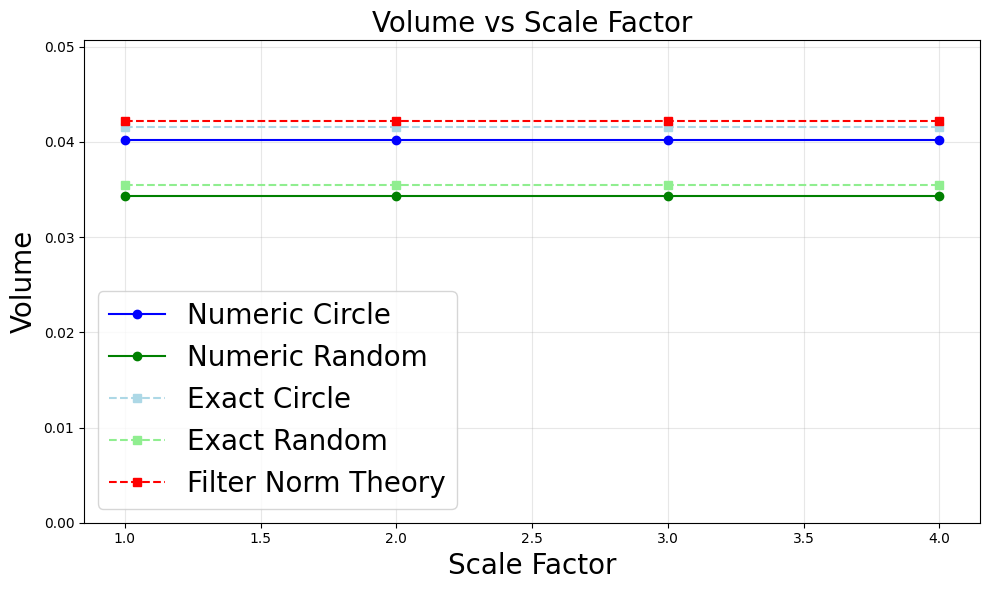

In [20]:
# Compute all volumes using all available samples (k = len(volume))
vol_circle, vol_random, vol_circle_exact, vol_random_exact = compute_all_volumes(
    circle_r_array, 
    random_r_array,
    exact_circle_r_array,
    exact_random_r_array,
    k=len(circle_r_array[0]),  # Using full sample size
    dimension=2
)

theoretical_volume = analytic_volume(a, w)
filter_theory_volume = theoretical_volume/a

# Create the plot
plt.figure(figsize=(10, 6))

# Plot numeric results
plt.plot(scale_factors, vol_circle, 'o-', label='Numeric Circle', color='blue')
plt.plot(scale_factors, vol_random, 'o-', label='Numeric Random', color='green')

# Plot exact results
plt.plot(scale_factors, vol_circle_exact, 's--', label='Exact Circle', color='lightblue')
plt.plot(scale_factors, vol_random_exact, 's--', label='Exact Random', color='lightgreen')

plt.plot(scale_factors, np.ones(len(scale_factors))*filter_theory_volume/np.pi, 's--', label='Filter Norm Theory', color='red')

# Add plot decorations
plt.xlabel('Scale Factor', fontsize=20)
plt.ylabel('Volume', fontsize=20)
plt.title('Volume vs Scale Factor', fontsize=20)
plt.legend(fontsize=20)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.2*filter_theory_volume/np.pi)

# Show plot
plt.tight_layout()
plt.savefig(f"experiments/a_{a}_w_{w}_n_perturb_{num_perturb_directions}/Volume_Scale.png")
plt.show()

# Plotting Across Minima Locations & Widths

We find very little dependence on the scale in all our examples. We can also test our expression to see it gives the right behaviour with respect to width or minima location (which is annoying, as it seems to affect the star-convexity).

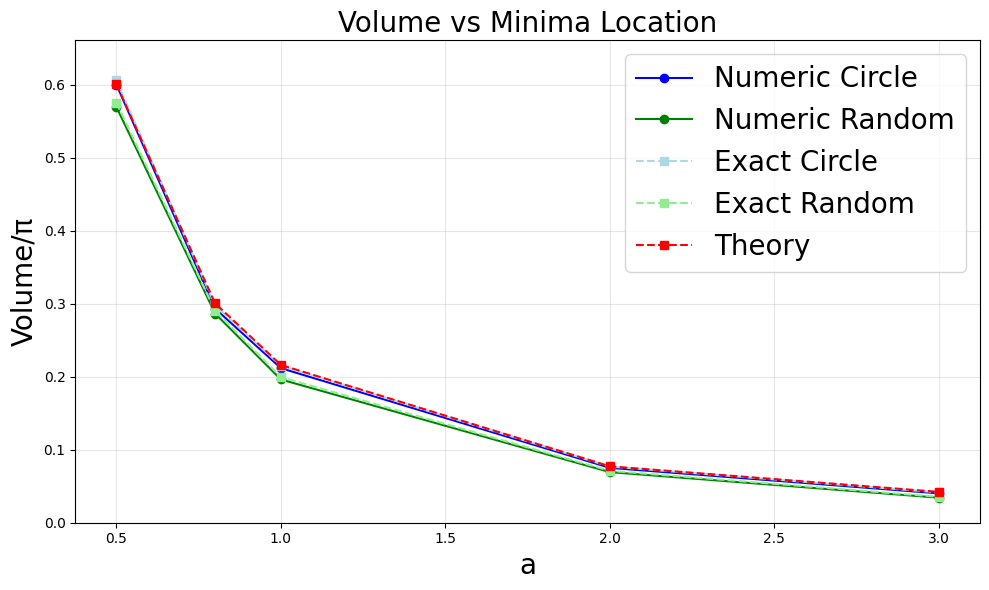

In [7]:
# Parameters
a_values = [0.5, 0.8, 1.0, 2.0, 3.0]
w = 0.2

# Initialize lists to store volume data
vol_circle_a = []
vol_random_a = []
vol_circle_exact_a = []
vol_random_exact_a = []
theoretical_volumes = []

for a in a_values:
    # Load data
    circle_r_array, random_r_array, exact_circle_r_array, exact_random_r_array = load_r_arrays_np(
        f"./experiments/a_{a}_w_{w}_n_perturb_{num_perturb_directions}/saved_results.npz"
    )
    
    # Compute volumes
    vol_circle, vol_random, vol_circle_exact, vol_random_exact = compute_all_volumes(
        circle_r_array, 
        random_r_array,
        exact_circle_r_array,
        exact_random_r_array,
        k=len(circle_r_array[0]),
        dimension=2
    )
    
    # Store first elements
    vol_circle_a.append(vol_circle[0])
    vol_random_a.append(vol_random[0])
    vol_circle_exact_a.append(vol_circle_exact[0])
    vol_random_exact_a.append(vol_random_exact[0])
    
    # Compute theoretical volume
    theoretical_volumes.append(analytic_volume(a, w)/(a*np.pi))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot numeric results
plt.plot(a_values, vol_circle_a, 'o-', label='Numeric Circle', color='blue')
plt.plot(a_values, vol_random_a, 'o-', label='Numeric Random', color='green')

# Plot exact results
plt.plot(a_values, vol_circle_exact_a, 's--', label='Exact Circle', color='lightblue')
plt.plot(a_values, vol_random_exact_a, 's--', label='Exact Random', color='lightgreen')

# Plot theoretical results
plt.plot(a_values, theoretical_volumes, 's--', label='Theory', color='red')

# Add plot decorations
plt.xlabel('a', fontsize=20)
plt.ylabel('Volume/π', fontsize=20)
plt.title('Volume vs Minima Location', fontsize=20)
plt.legend(fontsize=20)
plt.grid(True, alpha=0.3)

plt.ylim(0, 1.1*theoretical_volumes[0])

# Save and show plot
plt.tight_layout()
plt.savefig("./experiments/a_scaling.png")
plt.show()

w plotting

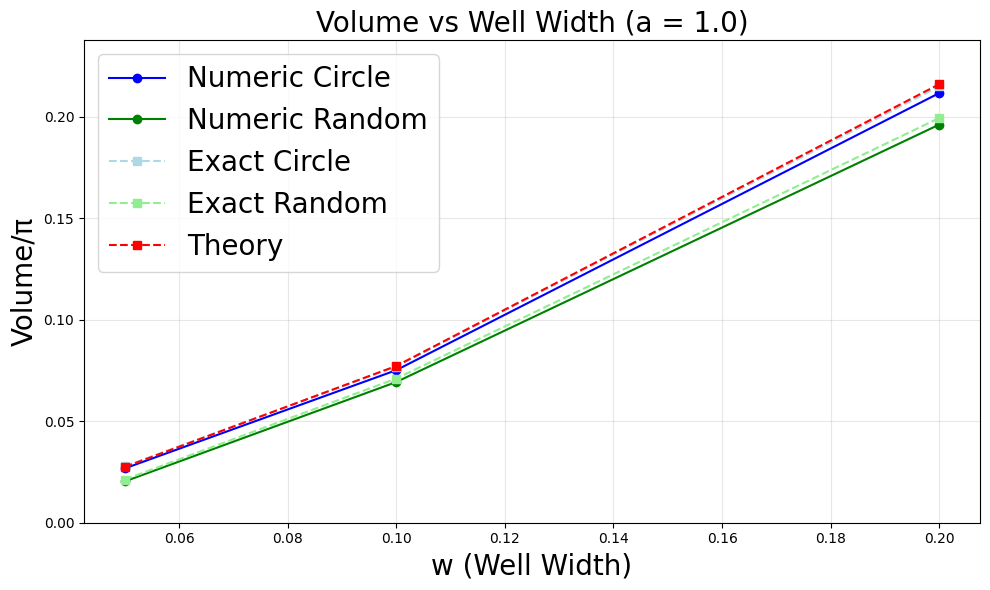

In [6]:
# Parameters
w_values = [0.05, 0.1, 0.2]
a = 1.0  # Fixed a value

# Initialize lists to store volume data
vol_circle_w = []
vol_random_w = []
vol_circle_exact_w = []
vol_random_exact_w = []
theoretical_volumes = []

for w in w_values:
    # Load data
    circle_r_array, random_r_array, exact_circle_r_array, exact_random_r_array = load_r_arrays_np(
        f"./experiments/a_{a}_w_{w}_n_perturb_{num_perturb_directions}/saved_results.npz"
    )
    
    # Compute volumes
    vol_circle, vol_random, vol_circle_exact, vol_random_exact = compute_all_volumes(
        circle_r_array, 
        random_r_array,
        exact_circle_r_array,
        exact_random_r_array,
        k=len(circle_r_array[0]),
        dimension=2
    )
    
    # Store first elements
    vol_circle_w.append(vol_circle[0])
    vol_random_w.append(vol_random[0])
    vol_circle_exact_w.append(vol_circle_exact[0])
    vol_random_exact_w.append(vol_random_exact[0])
    
    # Compute theoretical volume
    theoretical_volumes.append(analytic_volume(a, w)/np.pi)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot numeric results
plt.plot(w_values, vol_circle_w, 'o-', label='Numeric Circle', color='blue')
plt.plot(w_values, vol_random_w, 'o-', label='Numeric Random', color='green')

# Plot exact results
plt.plot(w_values, vol_circle_exact_w, 's--', label='Exact Circle', color='lightblue')
plt.plot(w_values, vol_random_exact_w, 's--', label='Exact Random', color='lightgreen')

# Plot theoretical results
plt.plot(w_values, theoretical_volumes, 's--', label='Theory', color='red')

# Add plot decorations
plt.xlabel('w (Well Width)', fontsize=20)
plt.ylabel('Volume/π', fontsize=20)
plt.title(f'Volume vs Well Width (a = {a})', fontsize=20)
plt.legend(fontsize=20)
plt.grid(True, alpha=0.3)

# Set y-axis limits
plt.ylim(0, 1.1 * theoretical_volumes[-1])

# Save and show plot
plt.tight_layout()
plt.savefig("./experiments/w_scaling.png")
plt.show()